In [ ]:
!pip install gymnasium

In [ ]:
!pip install gymnasium[toy-text]

In [ ]:
!pip install swig

In [ ]:
!pip install gymnasium[box2d]

In [ ]:
!pip install seaborn

In [ ]:
!pip install tqdm
!pip install torch

In [ ]:
import gymnasium as gym
import os
import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque


HyperParameters Q-Learning

In [7]:
# Hyperparameters
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor
epsilon = 1.0  # Exploration rate for Q_Learning and Deep Q-Learning
epsilon_min = 0.01 #For Q_Learning
epsilon_decay = 0.995 #For Q_Learning
num_training_episodes = 2000
num_evaluation_episodes = 1000
max_steps = 100 #For Approximate Q_learning and Q_Learning

## Q-Learning w/ Frozen Lake

In [8]:
# Create Frozen Lake environment
env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="rgb_array")  # Set is_slippery=True for stochastic environment

# Q-Learning algorithm function
# Q-Learning algorithm function
def q_learning(env, num_training_episodes, max_steps, alpha, gamma, epsilon, epsilon_min, epsilon_decay):
    # Initialize Q-table with zeros
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    episode_lengths = []
    episode_rewards = []

    # Function for Epsilon-Greedy policy
    def epsilon_greedy_action(state, Q, epsilon):
        if np.random.rand() < epsilon:
            return env.action_space.sample()  # Exploration
        else:
            return np.argmax(Q[state])  # Exploitation

    # Q-Learning loop
    for episode in tqdm(range(num_training_episodes)):
        state, _ = env.reset()
        state = int(state)
        done = False
        total_reward = 0
        steps = 0

        for step in range(max_steps):
            # Select action using epsilon-greedy policy
            action = epsilon_greedy_action(state, Q, epsilon)

            # Perform action and observe the next state and reward
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated  # Combine termination conditions

            # Update Q-value
            best_next_action = np.argmax(Q[next_state])
            Q[state, action] = Q[state, action] + alpha * (
                reward + gamma * Q[next_state, best_next_action] - Q[state, action]
            )

            # Update metrics
            total_reward += reward
            steps += 1

            # Move to the next state
            state = next_state

            if done:
                break

        # Record episode metrics
        episode_lengths.append(steps)
        episode_rewards.append(total_reward)

        # Decay epsilon to reduce exploration over time
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Extract the optimal policy from Q-table
    optimal_policy = np.argmax(Q, axis=1)
    return Q, optimal_policy, episode_lengths, episode_rewards

# Apply Q-learning
Q_table, optimal_policy_q_learning, episode_lengths, episode_rewards = q_learning(env, num_training_episodes, max_steps, alpha, gamma, epsilon, epsilon_min, epsilon_decay)

100%|██████████| 2000/2000 [00:00<00:00, 3505.78it/s]


In [9]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

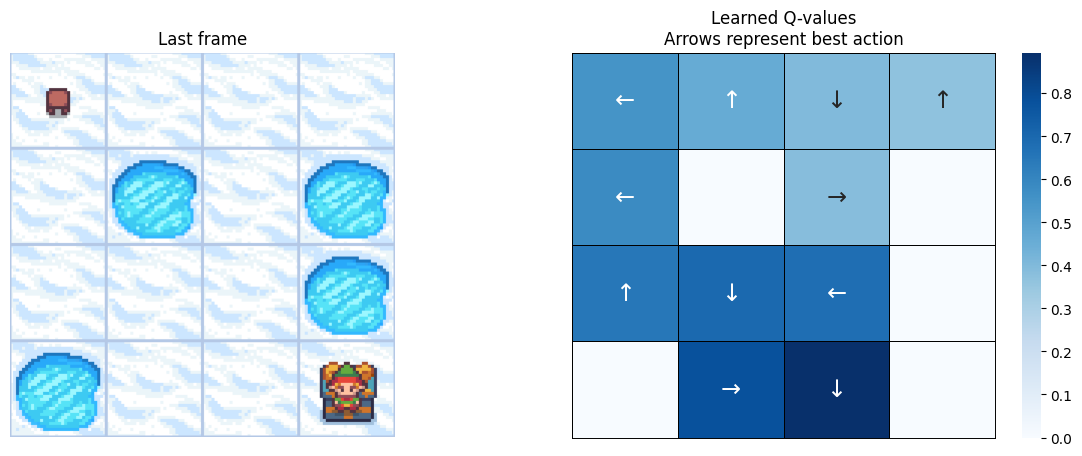

In [129]:
# Plot the last frame
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(env.render())
ax[0].axis("off")
ax[0].set_title("Last frame")

# Plot the policy
qtable_val_max, qtable_directions = qtable_directions_map(Q_table, map_size=4)
sns.heatmap(
    qtable_val_max,
    annot=qtable_directions,
    fmt="",
    ax=ax[1],
    cmap=sns.color_palette("Blues", as_cmap=True),
    linewidths=0.7,
    linecolor="black",
    xticklabels=[],
    yticklabels=[],
    annot_kws={"fontsize": "xx-large"},
).set(title="Learned Q-values\nArrows represent best action")
for _, spine in ax[1].spines.items():
    spine.set_visible(True)
    spine.set_linewidth(0.7)
    spine.set_color("black")

img_title = f"frozenlake_q_values_{4}x{4}.png"
savefig_folder = "./Qmap_images"  # Replace with your desired folder path
# Create the folder if it doesn't exist
os.makedirs(savefig_folder, exist_ok=True)
fig.savefig(os.path.join(savefig_folder, img_title), bbox_inches="tight")
plt.show()

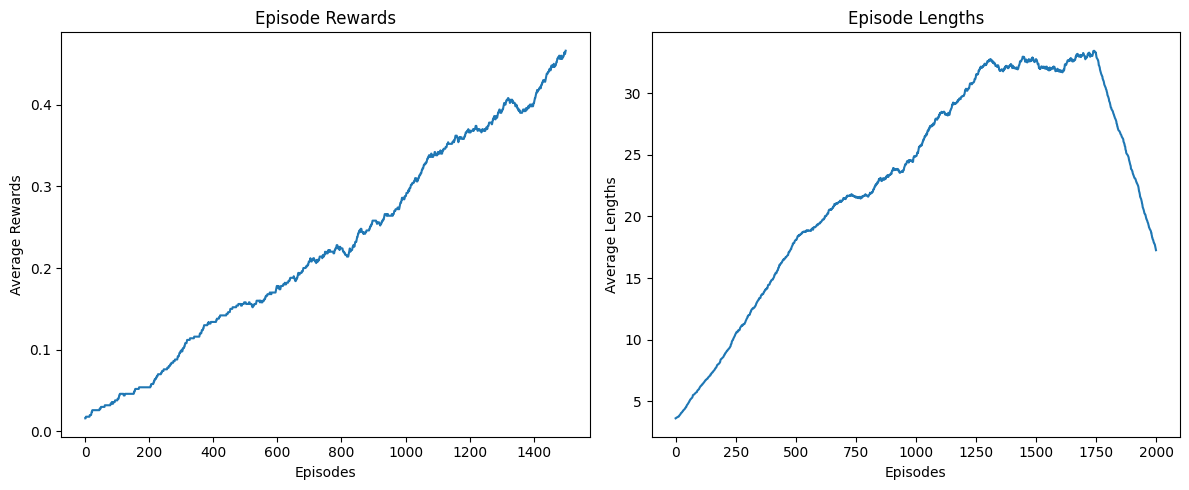

In [10]:
# Create the plots for rewards and lengths
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
rolling_length = 500

# Episode rewards plot
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(
        np.array(episode_rewards).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episodes")
axs[0].set_ylabel("Average Rewards")

# Episode lengths plot
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(
        np.array(episode_lengths).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episodes")
axs[1].set_ylabel("Average Lengths")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()
env.close()

In [11]:
def render_agent_movement(env, policy, max_steps):
    state, _ = env.reset()
    state = int(state)
    done = False
    print("Agent's movements:")
    for step in range(max_steps):
        env.render()
        action = policy[state]
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        if done:
            break
    env.close()

evaluation_env = gym.make("FrozenLake-v1", is_slippery=True, render_mode="human")
# Render the agent's movements
render_agent_movement(evaluation_env, optimal_policy_q_learning, max_steps)
evaluation_env.close()


Agent's movements:


## Aproximate Q-Learning w/ Mountain Car

HyperParameters Approx. QLearning


In [48]:
alpha = 0.9  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate for Q_Learning and Deep Q-Learning
epsilon_decay = 0.995 #For Q_Learning
num_training_episodes = 5000
num_evaluation_episodes = 1000
epsilon_min = 2/num_training_episodes #For Q_Learning

In [49]:
def train_approx_qlearning(env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, num_training_episodes):
    # Divide position and velocity into segments
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07
    q = np.zeros((len(pos_space), len(vel_space), env.action_space.n)) # init a 20x20x3 array
    rng = np.random.default_rng()
    episode_lengths = []
    episode_rewards = []

    for episode in tqdm(range(num_training_episodes)):
        state, _ = env.reset()  # Reset Gymnasium environment
        done = False
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        total_reward = 0
        steps = 0

        while(not done and total_reward>-1000):

             # Take action
            if  rng.random() < epsilon:
            # Choose random action (0=drive left, 1=stay neutral, 2=drive right)
                action = env.action_space.sample()
            else:
                action = np.argmax(q[state_p, state_v, :])

           
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state_p = np.digitize(next_state[0], pos_space)
            next_state_v = np.digitize(next_state[1], vel_space)
            
            done = terminated or truncated

            # Update weights
            q[state_p, state_v, action] = q[state_p, state_v, action] + alpha * (
                reward + gamma*np.max(q[next_state_p, next_state_v,:]) - q[state_p, state_v, action]
            )
           
            state = next_state
            state_p = next_state_p
            state_v = next_state_v

            # Update metrics
            total_reward += reward
            steps += 1

        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        
        episode_lengths.append(steps)
        episode_rewards.append(total_reward)
    
    return episode_rewards, episode_lengths, q


In [50]:
env = gym.make("MountainCar-v0", render_mode = "rgb_array")
episode_rewards, episode_lengths, q = train_approx_qlearning(env, alpha, gamma, epsilon, epsilon_decay, epsilon_min, num_training_episodes)

100%|██████████| 5000/5000 [00:38<00:00, 130.52it/s]


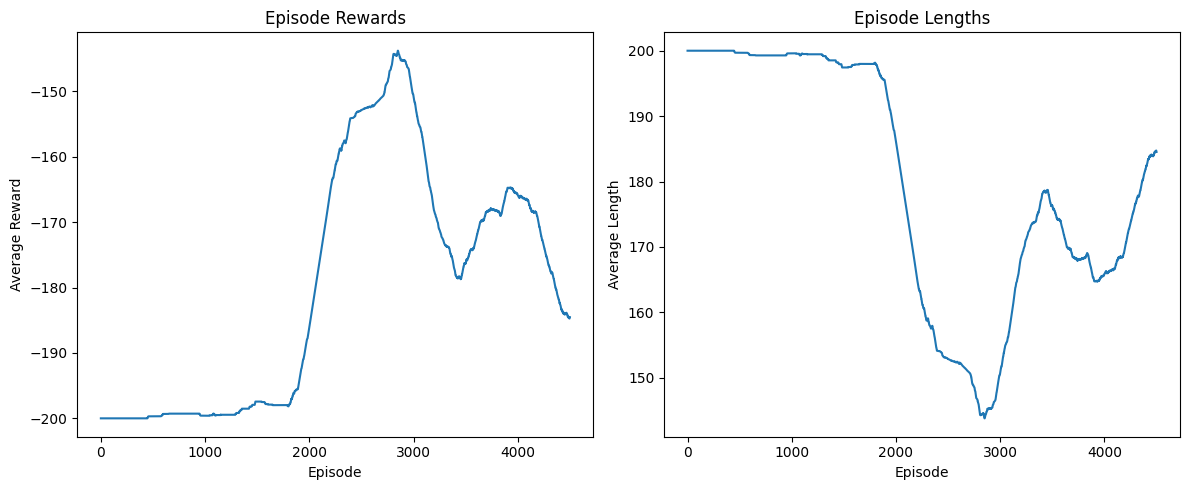

In [51]:
# Plot rewards and lengths
rolling_length = 500  # Adjust the rolling average window for smoothing                                                                                                                     
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Episode rewards
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(np.array(episode_rewards), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Reward")

# Episode lengths
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(np.array(episode_lengths), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Average Length")

plt.tight_layout()
plt.show()

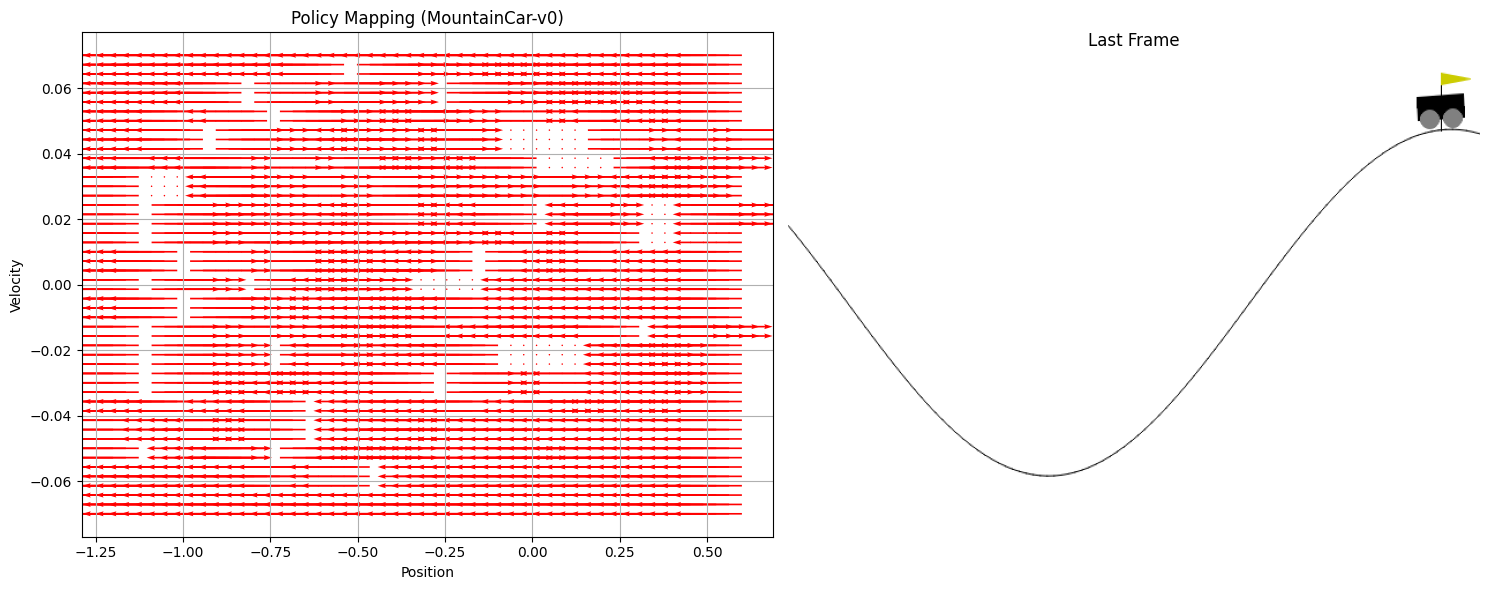

In [52]:
def map_policy_with_arrows(env, q, grid_points=20):
    """
    Map the learned policy onto a grid with arrows.
    Args:
    - env: The Gymnasium environment.
    - q: Learned Q-table (discretized states and actions).
    - grid_points: Number of points to sample along each dimension.

    Returns:
    - X, Y: Meshgrid for positions and velocities.
    - U, V: Arrow directions based on policy actions.
    """
    # Generate grid points for position and velocity
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    pos_space = np.linspace(state_bounds[0][0], state_bounds[0][1], grid_points)
    vel_space = np.linspace(state_bounds[1][0], state_bounds[1][1], grid_points)
    X, Y = np.meshgrid(pos_space, vel_space)
    U = np.zeros_like(X)  # Arrows for position direction
    V = np.zeros_like(Y)  # Arrows for velocity direction

    # Iterate over grid points and determine actions
    for i in range(grid_points):
        for j in range(grid_points):
            state_p = np.digitize(X[i, j], np.linspace(state_bounds[0][0], state_bounds[0][1], q.shape[0]))
            state_v = np.digitize(Y[i, j], np.linspace(state_bounds[1][0], state_bounds[1][1], q.shape[1]))
            action = np.argmax(q[state_p - 1, state_v - 1, :])  # Action from Q-table

            # Set arrow directions based on the action
            if action == 0:  # Drive left
                U[i, j] = -1
                V[i, j] = 0
            elif action == 1:  # Do nothing
                U[i, j] = 0
                V[i, j] = 0
            elif action == 2:  # Drive right
                U[i, j] = 1
                V[i, j] = 0

    return X, Y, U, V

def plot_policy_arrows(X, Y, U, V, env):
    """
    Plot the policy map with arrows using quiver.
    Args:
    - X, Y: Meshgrid of positions and velocities.
    - U, V: Arrow directions based on policy actions.
    - env: The Gymnasium environment for rendering the last frame.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot the policy map with arrows
    ax1.quiver(X, Y, U, V, scale=10, color="r")
    ax1.set_title("Policy Mapping (MountainCar-v0)")
    ax1.set_xlabel("Position")
    ax1.set_ylabel("Velocity")
    ax1.grid(True)

    # Plot the last frame from the environment
    ax2.imshow(env.render())
    ax2.set_title("Last Frame")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

grid_points = 50  # Higher value for finer resolution
pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)
vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)

# Map policy to arrows
X, Y, U, V = map_policy_with_arrows(env, q, grid_points)

# Plot the policy map
plot_policy_arrows(X, Y, U, V, env)
env.close()

In [56]:
def render_car_policy(env, q):
    """
    Evaluate the learned policy by rendering it.
    env_name: The name of the Gymnasium environment.
    theta: Trained weights for the approximate Q-learning model.
    episodes: Number of episodes to play for visualization.
    """
    state, _ = env.reset()
    pos_space = np.linspace(env.observation_space.low[0], env.observation_space.high[0], 20)    # Between -1.2 and 0.6
    vel_space = np.linspace(env.observation_space.low[1], env.observation_space.high[1], 20)    # Between -0.07 and 0.07
    state_p = np.digitize(state[0], pos_space)
    state_v = np.digitize(state[1], vel_space)
    total_reward = 0
    steps = 0
    done = False

    while not done:
        # Select the best action based on the learned Q-table
        action = np.argmax(q[state_p, state_v, :])
        
        # Take the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)

        # Update the state
        state = next_state
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)

        # Update metrics
        total_reward += reward
        steps += 1

        # Check if the episode is done
        done = terminated or truncated

evaluation_car_env = gym.make("MountainCar-v0", render_mode="human")

# Render the agent's movements
render_car_policy(evaluation_car_env, q)

evaluation_car_env.close()

## Deep Q-Learning


Hyperparameters

In [ ]:
alpha = 0.9  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate for Q_Learning and Deep Q-Learning
epsilon_decay = 0.995 #For Q_Learning
num_training_episodes = 5000
num_evaluation_episodes = 1000
epsilon_min = 2/num_training_episodes #For Q_Learning

Libraries and Initialize the Environment

In [28]:
# Initialize the Lunar Lander environment
env = gym.make("LunarLander-v3", render_mode="rgb_array")

# Set the random seed for reproducibility
seed = 42
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Set random seed for reproducibility
seed = 42
env.reset(seed=seed)
np.random.seed(seed)
torch.manual_seed(seed)


DependencyNotInstalled: Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"`

Define the Neural Network (DQN)

In [ ]:
class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


Define the Replay Buffer

In [ ]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.memory = deque(maxlen=buffer_size)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.memory), batch_size, replace=False)
        return [self.memory[idx] for idx in indices]

    def __len__(self):
        return len(self.memory)


DQN Agent

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, buffer_size, batch_size, learning_rate, gamma, epsilon, epsilon_decay, min_epsilon):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size

        # Replay buffer
        self.memory = ReplayBuffer(buffer_size)

        # Q-Network
        self.qnetwork = DQNetwork(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.qnetwork.parameters(), lr=learning_rate)

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice(range(self.action_size))  # Random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                return torch.argmax(self.qnetwork(state_tensor)).item()  # Greedy action

    def learn(self):
        if len(self.memory) < self.batch_size:
            return

        # Sample a batch
        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).to(device)

        # Compute Q-values and target Q-values
        q_values = self.qnetwork(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.qnetwork(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Loss
        loss = nn.MSELoss()(q_values, target_q_values.detach())

        # Optimize the network
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay epsilon
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)


Training Loop

In [ ]:
# Hyperparameters
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
buffer_size = 150000
batch_size = 64

# Initialize agent
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
agent = DQNAgent(state_size, action_size, buffer_size, batch_size, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

# Training loop
rewards = []
episode_lengths = []

#CHANGE TRAINING EPISODES IN THE HYPERPARAMETER CELL IF ITS TOO LARGE
for episode in tqdm(range(1, num_training_episodes + 1)):
    state, _ = env.reset()
    total_reward = 0
    step_count = 0
    for t in range(max_steps):
        action = agent.act(state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        agent.memory.add((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward
        step_count += 1

        if done:
            break
    agent.learn()
    rewards.append(total_reward)
    episode_lengths.append(step_count)

# Save the trained model
torch.save(agent.qnetwork.state_dict(), "dqn_lunar_lander.pth")


100%|██████████| 10000/10000 [05:58<00:00, 27.91it/s]


Plot Results

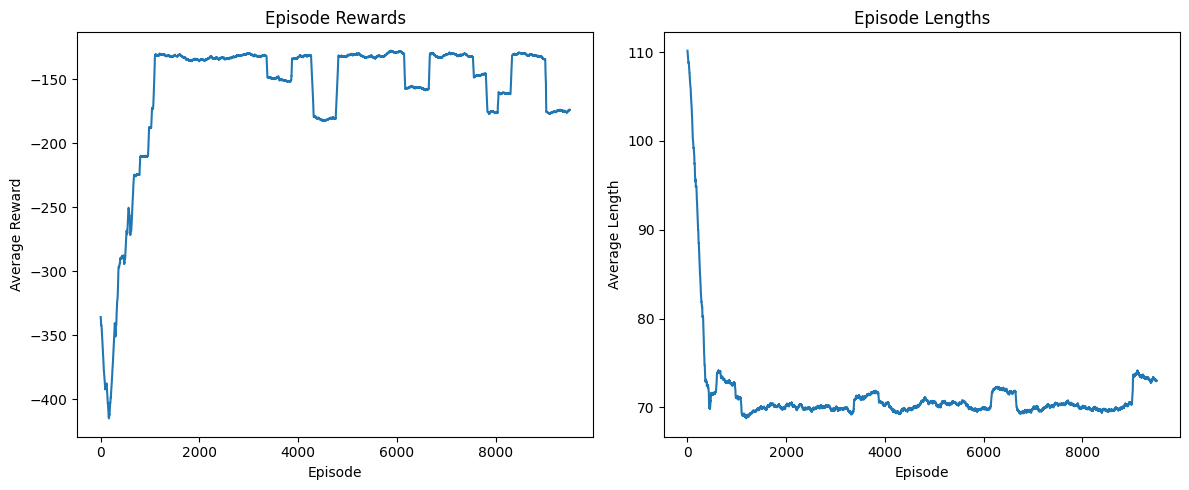

In [ ]:
# Plot rewards and lengths
rolling_length = 500  # Adjust the rolling average window for smoothing
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))

# Episode rewards
axs[0].set_title("Episode Rewards")
reward_moving_average = (
    np.convolve(np.array(rewards), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Average Reward")

# Episode lengths
axs[1].set_title("Episode Lengths")
length_moving_average = (
    np.convolve(np.array(episode_lengths), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Average Length")

plt.tight_layout()
plt.show()

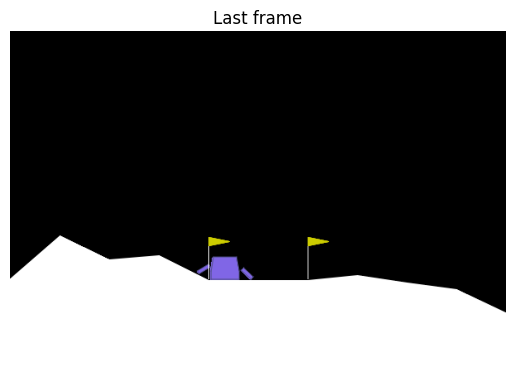

In [ ]:
#Plot last frame
plt.imshow(env.render())
plt.title("Last frame")
plt.axis("off")
plt.show()

Test the Agent

In [ ]:
# Load the trained model
agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.qnetwork.eval()

# Run one episode to visualize
state, _ = env.reset()
done = False
while not done:
    action = agent.act(state)
    state, _, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
env.close()


  agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))



In [ ]:
# Load the trained model
agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))
agent.qnetwork.eval()

# Initialize variables for testing
total_rewards = []

print("Testing the trained agent...\n")

for episode in range(1, num_evaluation_episodes + 1):
    state, _ = env.reset()
    done = False
    episode_reward = 0

    while not done:
        # Select the action greedily (without exploration)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action = torch.argmax(agent.qnetwork(state_tensor)).item()

        # Perform the action in the environment
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Accumulate reward
        episode_reward += reward
        state = next_state

        # Render the environment (optional)
        env.render()

    total_rewards.append(episode_reward)

env.close()

# Calculate average performance
average_reward = np.mean(total_rewards)
print(f"\nAverage Reward over {num_evaluation_episodes} episodes: {average_reward:.2f}")


  agent.qnetwork.load_state_dict(torch.load("dqn_lunar_lander.pth"))



Testing the trained agent...


Average Reward over 1000 episodes: -131.05
